# Compute False Positives and Negatives for Each Label Type

This should help with error analysis

We take as input the .csv exported from the save_classifications.py file

In [1]:
import os
import csv
from collections import defaultdict
import random
import matplotlib.pyplot as plt
import shutil
import numpy as np

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [2]:
num_to_sample = 75

In [10]:
predictions_csv = '20ep_new_old_re18_2.csv' # using ground truth

In [3]:
dataset_path = '/mnt/g/ground_truth_cc_dataset'

output_path = 'output_true'
if not os.path.isdir(output_path):
    os.mkdir(output_path)

In [4]:
false_pos = defaultdict(set)
# these are things that shouldn't have been labeled as [label] but were

false_neg = defaultdict(set)
# these are things that should have been labeled as [label] but weren't

true_pos = defaultdict(set)
# correct!

In [5]:
with open(predictions_csv) as f:
    reader = csv.DictReader(f)
    num_items = 0
    num_wrong = 0
    for item in reader:
        num_items += 1
        actual    = item['Actual']
        predicted = item['Predicted']
        
        if actual != predicted:
            num_wrong += 1
            false_pos[predicted].add(item['File'])
            false_neg[actual   ].add(item['File'])
        
        else:
            true_pos[actual].add(item['File'])
            
print "Counted {} items, {:5.2f}% correct.".format(num_items, 100*(float(num_items - num_wrong)/num_items))
print ""
print "{:<15} {:<5} {:<5}".format("Label", "#FP", "#FN")
for label, fp in false_pos.items():
    fn = false_neg[label]
    print "{:<15} {:<5} {:<5}".format(label, len(fp), len(fn))

Counted 20461 items, 89.99% correct.

Label           #FP   #FN  
sfc_problem     171   356  
null            115   85   
missing_ramp    368   742  
ramp            1037  464  
obstruction     357   401  


In [231]:
# premade example here https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          cmap=plt.cm.Blues, cbar=False, figsize=(3,3)):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """


    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm = cm.T
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    if cbar: ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           xlabel='True label',
           ylabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '0.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt)[1:],
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black", fontsize=16)
    fig.set_size_inches(figsize)
    fig.tight_layout()
    return ax

In [232]:
pretty_labels = ('Ramp', 'Missing Ramp', 'Sfc Problem', 'Obstruction', 'Null')
ugly_labels   = ('ramp', 'missing_ramp', 'sfc_problem', 'obstruction', 'null')

y_true = []
y_pred = []

with open(predictions_csv) as f:
    reader = csv.DictReader(f)
    num_items = 0
    for item in reader:
        num_items += 1
        actual    = ugly_labels.index(item['Actual'])
        predicted = ugly_labels.index(item['Predicted'])
        
        y_true.append(actual)
        y_pred.append(predicted)

Normalized confusion matrix
[[0.9318122  0.03761178 0.01196739 0.01643872 0.00216991]
 [0.11882427 0.76985616 0.04878049 0.04690432 0.01563477]
 [0.09090909 0.06926407 0.75324675 0.07359307 0.01298701]
 [0.07350187 0.04681648 0.03838951 0.83286517 0.00842697]
 [0.06545455 0.02666667 0.0169697  0.03030303 0.86060606]]


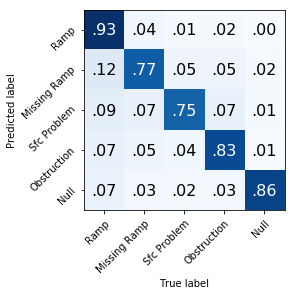

In [233]:
plot_confusion_matrix(y_true, y_pred, np.array(pretty_labels), normalize=True,cmap=plt.cm.Blues, figsize=(4.2,5))
plt.savefig('/Users/galenweld/sidewalk-cv-assets19/figures_for_paper/pngs/confusion_matrix.png', dpi = 300)
plt.show()

# copy predictions to directories

In [22]:
#for kind, d in (('false_pos', false_pos), ('false_neg', false_neg), ('true_pos', true_pos)):
for kind, d in (('true_pos', true_pos),):

    if not os.path.isdir( os.path.join(output_path, kind) ):
        os.mkdir( os.path.join(output_path, kind) )
    
    for label, paths in d.items():
        if len(paths) > num_to_sample:
            sample = random.sample(paths, num_to_sample)
        else: sample = paths
        for shortpath in sample:
            completepath = os.path.join(dataset_path, shortpath)
            _, filename = os.path.split(shortpath)
            destdir = os.path.join(output_path, kind, label)
            if not os.path.isdir(destdir):
                os.mkdir(destdir)
            destpath = os.path.join(destdir, filename)
            shutil.copy(completepath, destpath)

# Bar plot of precision and recall?

In [6]:
class_actual    = defaultdict(int)
class_predicted = defaultdict(int)
class_correct   = defaultdict(int)

count = 0
with open('20ep_new_old_re18_2.csv') as f:
    reader = csv.DictReader(f)
    for row in reader:
        a = row['Actual']
        p = row['Predicted']
        
        class_actual[a] += 1
        class_predicted[p] += 1
        if a==p:
            class_correct[a] += 1
        count += 1

print "Processed predictions for {} imgs.".format(count)

Processed predictions for 20461 imgs.


In [57]:
pr = {}
rc = {}

print("{:<20}{:^6}   {:^6}   {:^6}".format("Label", "p", "r", "num"))
for label in class_actual:
    correct   = float(class_correct[label])
    predicted = float(class_predicted[label])
    actual    = float(class_actual[label])

    p = 100 * (correct / predicted) if predicted >0 else float('nan')
    r = 100 * (correct / actual)
    
    pr[label] = p
    rc[label] = r

    print("{:20}{:06.2f}%  {:06.2f} {:6d}".format(label, p, r, int(actual)))
correct = float(sum(class_correct.values()))
predicted = float(sum(class_predicted.values()))
actual = float(sum(class_actual.values()))

p = 100 * (correct / predicted) if predicted >0 else float('nan')
r= 100 * (correct / actual)
print("{:20}{:06.2f}%  {:06.2f} {:6d}".format("Overall", p, r, int(actual)))

pr["Overall"] = p
rc["Overall"] = r

Label                 p        r       num  
sfc_problem         075.32%  059.45    878
obstruction         083.29%  081.61   2180
null                086.06%  089.31    795
ramp                093.18%  096.83  14635
missing_ramp        076.99%  062.39   1973
Overall             089.99%  089.99  20461


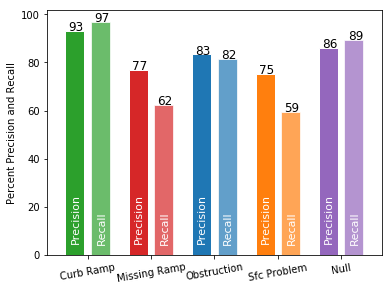

In [235]:
pretty_labels = ('Curb Ramp', 'Missing Ramp', 'Sfc Problem', 'Obstruction', 'Null', "Overall")
ugly_labels   = ('ramp', 'missing_ramp', 'sfc_problem', 'obstruction', 'null', "Overall")

label_colors = (('Curb Ramp', 'C2'), ('Missing Ramp', 'C3'), ('Obstruction','C0'), ('Sfc Problem','C1'), ('Null','C4'))

plt.figure(figsize=(6,4.5))

p_xs     = []
r_xs = []
p_heights= []
r_heights = []
p_widths = len(label_colors) * [-.3]
r_widths = len(label_colors) * [.3]
colors = []

for i, (label, color) in enumerate(label_colors):
    ugly_label = ugly_labels[pretty_labels.index(label)]
    
    p = pr[ugly_label]
    r = rc[ugly_label]
    
    colors += [color]
    p_heights.append(p)
    r_heights.append(r)
    p_xs.append(i-.1)
    r_xs.append(i)
        
plt.bar(p_xs, p_heights, tick_label=None, align='edge', width=p_widths, color=colors, hatch='', ec='white')
plt.bar(r_xs, r_heights, tick_label=None, align='edge', width=r_widths, color=colors, hatch='', ec='white', alpha=.7)
plt.bar(np.array(range(len(label_colors)))-.05, len(label_colors)*[0], tick_label = zip(*label_colors)[0], align='center')

for x in range(len(label_colors)):
    plt.text(x-.32, 22, "Precision", rotation='vertical', color="white", fontsize=11)
    plt.text(x+.09, 15, "Recall", rotation='vertical', color="white", fontsize=11)
    
for xs, heights, offset in ((p_xs, p_heights, -.25), (r_xs, r_heights, .05)):
    for x, h in zip(xs, heights):
        plt.text(x+offset, h+0, "{:2.0f}".format(h), fontsize=12)
        
plt.xticks(rotation=10)

plt.ylabel("Percent Precision and Recall")
plt.savefig('/Users/galenweld/sidewalk-cv-assets19/figures_for_paper/pngs/pr_bar.png', dpi = 300)
plt.show()